In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,kpss
from scipy.stats import ks_2samp
import warnings
warnings.filterwarnings("ignore")

#### Objective:
Predict **next 7 days Tesla (TSLA) daily closing prices** using historical daily candle close data.

In [2]:
stock_data=yf.download('TSLA',start='2010-06-29')


[*********************100%***********************]  1 of 1 completed


In [3]:
stock_data.head(5)

Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2010-06-29,1.592667,1.666667,1.169333,1.266667,281494500
2010-06-30,1.588667,2.028000,1.553333,1.719333,257806500
2010-07-01,1.464000,1.728000,1.351333,1.666667,123282000
2010-07-02,1.280000,1.540000,1.247333,1.533333,77097000
2010-07-06,1.074000,1.333333,1.055333,1.333333,103003500


In [4]:
stock_data.tail(5)

Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2026-01-26,435.200012,445.040009,434.279999,445.000000,49397400
2026-01-27,430.899994,437.519989,430.690002,437.410004,37733100
2026-01-28,431.459991,438.260010,430.100006,431.910004,54857400
2026-01-29,416.559998,440.230011,414.619995,437.799988,81686100
2026-01-30,430.410004,439.880005,422.700012,425.350006,82483000


In [5]:
stock_data.describe()

Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
count,3922.000000,3922.000000,3922.000000,3922.000000,3.922000e+03
mean,100.894970,103.119971,98.580966,100.924721,9.657460e+07
std,127.289094,130.113869,124.406439,127.389702,7.555416e+07
min,1.053333,1.108667,0.998667,1.076000,1.777500e+06
25%,12.846667,13.009334,12.585500,12.808833,5.146275e+07
50%,20.019667,20.398000,19.623333,20.016667,8.297255e+07
75%,209.814999,215.612499,205.344170,209.922501,1.208290e+08
max,489.880005,498.829987,485.329987,489.880005,9.140820e+08


### Insights

- Price ranged from **~$1 to ~$490**, showing massive long-term growth.
- **75% of data lies below ~$210**, meaning recent highs dominate the averages.
- **Median close (~$20)** is far below the mean, indicating a strong **right-skew** due to recent price surge.
- **Trading volume is very high and volatile**, reflecting strong market interest.


In [6]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3922 entries, 2010-06-29 to 2026-01-30
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, TSLA)   3922 non-null   float64
 1   (High, TSLA)    3922 non-null   float64
 2   (Low, TSLA)     3922 non-null   float64
 3   (Open, TSLA)    3922 non-null   float64
 4   (Volume, TSLA)  3922 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 183.8 KB


### EDA

In [7]:
stock_data.columns=['Close','High','Low','Open','Volume']
stock_data.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [8]:
stock_data['Date']=stock_data.index

In [9]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3922 entries, 2010-06-29 to 2026-01-30
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Close   3922 non-null   float64       
 1   High    3922 non-null   float64       
 2   Low     3922 non-null   float64       
 3   Open    3922 non-null   float64       
 4   Volume  3922 non-null   int64         
 5   Date    3922 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 214.5 KB


In [10]:
stock_data.reset_index(drop=True,inplace=True)
stock_data=stock_data[['Date','Open','High','Low','Close','Volume']]
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3922 entries, 0 to 3921
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3922 non-null   datetime64[ns]
 1   Open    3922 non-null   float64       
 2   High    3922 non-null   float64       
 3   Low     3922 non-null   float64       
 4   Close   3922 non-null   float64       
 5   Volume  3922 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 184.0 KB


In [18]:
fig = px.line(
    stock_data,
    x='Date',
    y=stock_data.columns,
    title='Tesla Stock Data',
    markers=True,
    template='plotly_dark'
)
fig.update_layout(
    title=dict(x=0.5, xanchor='center'),
    xaxis_title='Date',
    yaxis_title='Value (USD)'
)
fig.show()

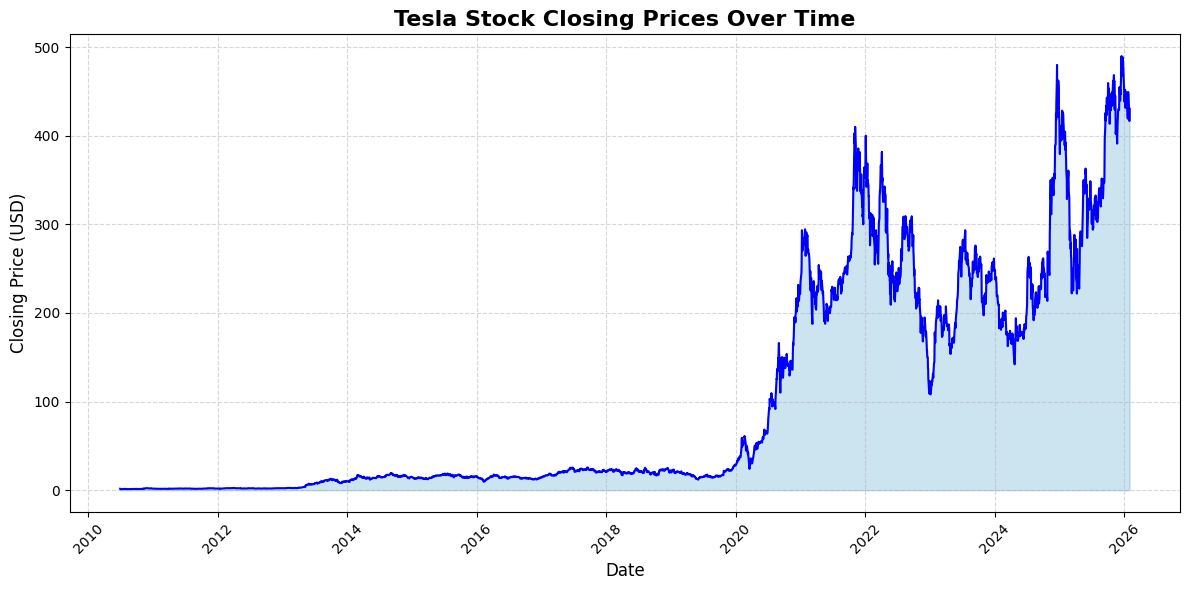

In [32]:
plt.figure(figsize=(12,6))
plt.plot(
    stock_data['Date'], 
    stock_data['Close'], 
    color='blue',  # deep blue
    linewidth=1.5
)
plt.fill_between(
    stock_data['Date'], 
    stock_data['Close'], 
    color='#0077b6', 
    alpha=0.2
)

plt.title('Tesla Stock Closing Prices Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Closing Price (USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



We will apply **multiplicative model** here.

**Reason:**  The swings in price get bigger as the price rises, especially after 2020.  

So we apply **Classical Decomposition here**.


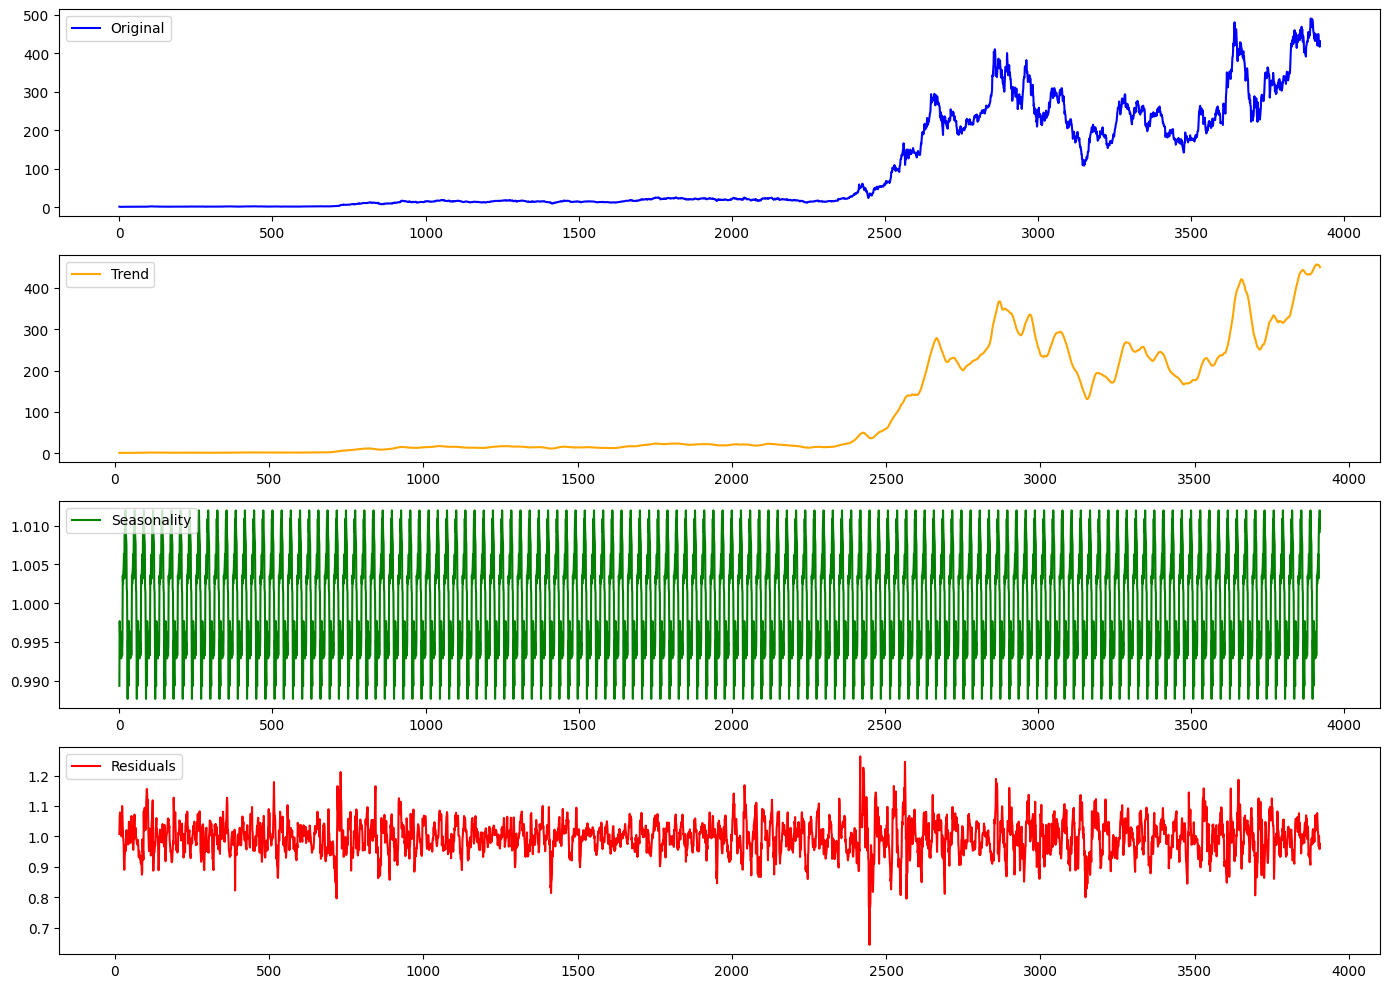

In [34]:
decomposition_multiplicative=seasonal_decompose(
    stock_data['Close'],
    model='multiplicative',
    period=30)
trend_multiplicative=decomposition_multiplicative.trend
seasonal_multiplicative=decomposition_multiplicative.seasonal
residual_multiplicative=decomposition_multiplicative.resid

plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(stock_data['Close'], label='Original', color='blue')
plt.legend(loc='upper left')
plt.subplot(412)    
plt.plot(trend_multiplicative, label='Trend', color='orange')
plt.legend(loc='upper left')    
plt.subplot(413)
plt.plot(seasonal_multiplicative, label='Seasonality', color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual_multiplicative, label='Residuals', color='red')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


## Insights

### Trend (Orange)
- **Observation:** Slow rise until 2019, sharp acceleration from 2020.  
- **Insight:** Confirms long-term bullish trend; non-linear growth makes STL suitable.

### Seasonality (Green)
- **Observation:** Very minor, almost flat.  
- **Insight:** Seasonal effects negligible; price driven mainly by trend and residuals.

### Residuals (Red)
- **Observation:** High volatility, spikes post-2020.  
- **Insight:** Captures unexpected jumps/noise; magnitude rises with price (heteroscedasticity).


# **STATIONARITY CHECK NOW**

In [41]:
adf_test=adfuller(stock_data['Close'])
print("ADF Test Results")
print(f"ADF Statistic: {adf_test[0]}")
print(f"P-value: {adf_test[1]}")
print("Critical Values:")
for key, value in adf_test[4].items():
    print(f"   {key}: {value}")

if adf_test[1] < 0.05:
    print("\nStationary Data")
else:
    print("\n Non Stationary Data")

ADF Test Results
ADF Statistic: -0.621076300539925
P-value: 0.8661481774655967
Critical Values:
   1%: -3.4320317320238214
   5%: -2.862283097095044
   10%: -2.5671655594763263

 Non Stationary Data


In [45]:
kpss_test=kpss(stock_data['Close'],regression='ct',nlags="auto")
print("\nKPSS Test Results")
print(f"KPSS Statistic: {kpss_test[0]}")
print(f"P-value: {kpss_test[1]}")
print("Critical Values:")
for key, value in kpss_test[3].items():
    print(f"   {key}: {value}")

if kpss_test[1] < 0.05:
    print("\n Non Stationary Data") 
else:
    print("\nStationary Data")


KPSS Test Results
KPSS Statistic: 1.2856950582130948
P-value: 0.01
Critical Values:
   10%: 0.119
   5%: 0.146
   2.5%: 0.176
   1%: 0.216

 Non Stationary Data
